In [1]:
import pandas as pd

# CSV 파일에서 데이터 읽기
df = pd.read_csv('Data/using/dt_2.6/ByAstar_dt_2.6_modified.csv')

df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17304 entries, 0 to 17303
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gate length     17304 non-null  int64  
 1   Theta           17304 non-null  float64
 2   Phi             17304 non-null  float64
 3   dt              17304 non-null  float64
 4   combination     17304 non-null  object 
 5   total time      17304 non-null  float64
 6   computing time  17304 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 946.4+ KB


array([[<Axes: title={'center': 'gate length'}>,
        <Axes: title={'center': 'Theta'}>],
       [<Axes: title={'center': 'Phi'}>, <Axes: title={'center': 'dt'}>],
       [<Axes: title={'center': 'total time'}>,
        <Axes: title={'center': 'computing time'}>]], dtype=object)

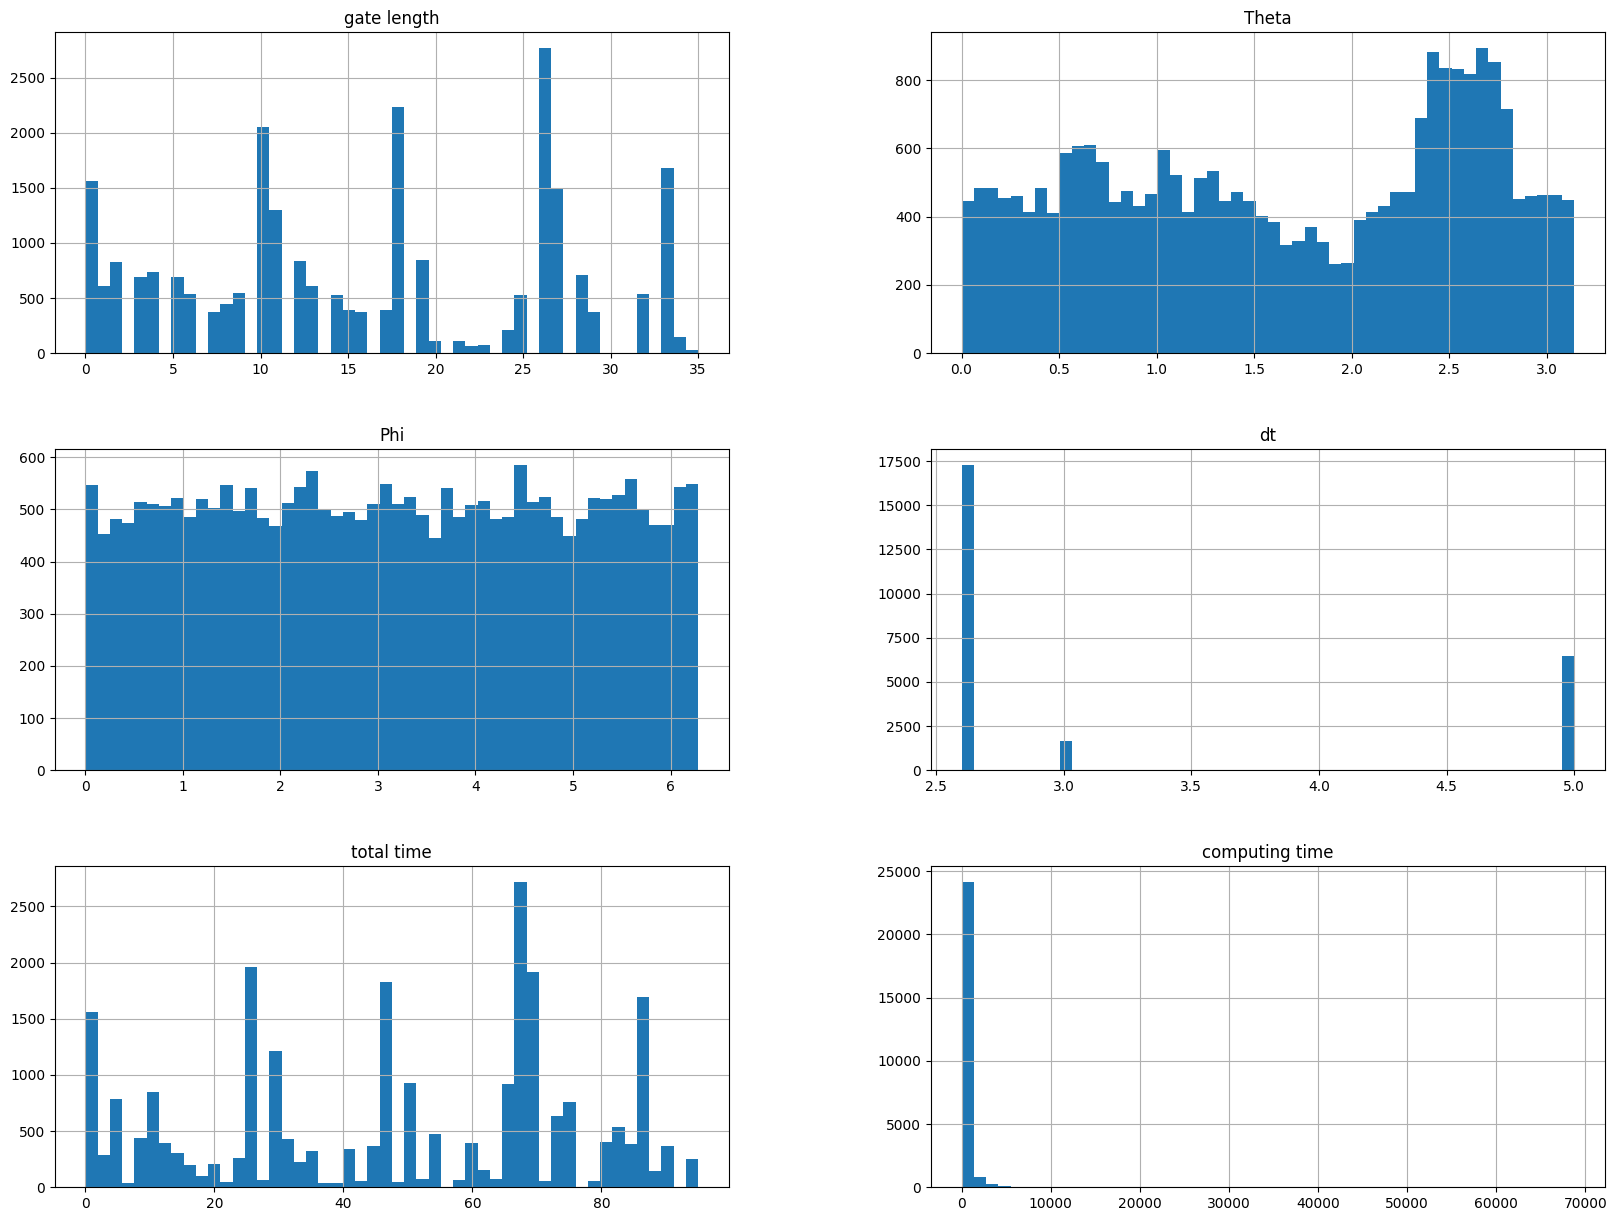

In [37]:
import matplotlib as plt

%matplotlib inline
df.hist(bins=50, figsize=(20,15))

# 히스토그램(주어진 값 범위 수평축, 샘플 수 수직축)

<Axes: xlabel='Theta', ylabel='Phi'>

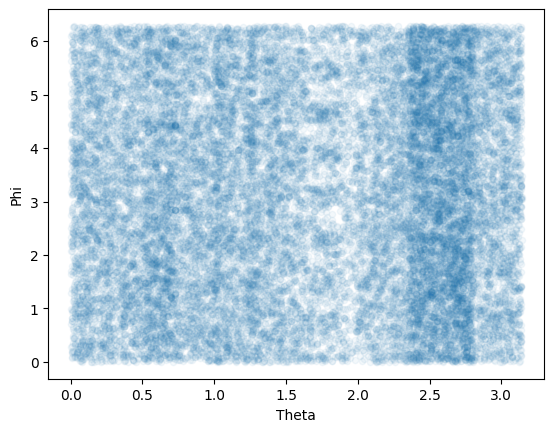

In [38]:
df.plot(kind = "scatter", x="Theta", y="Phi", alpha=0.05)